# GraphSAGE

## Model Definition
GraphSAGE which is short for Graph Sample and Aggregate, is another type of GNN which draw similarities to GCNs such that it is largely dependent on the features of itself and it's local neighbourhood. However, the important distinction in this method is the usage of sampling only $u$ neighbours and the utlilisation of trainable aggregator functions, specifically, aggregation methods such as Max Pool, Mean and LSTM.

\
In essence, the sample and aggregate function can be defined as follows,

$\text{AGGREGATE}_k\left(\left\{ \mathbf{h}_u^{k-1} \mid u \in \mathcal{N}(v)\right\}\right)$
$\text{where } \text{AGGREGATE}_k \in \{\text{Mean}, \text{MaxPool}, \text{LSTM}\}, \quad \mathcal{N}(v) \text{ produces a fixed-size sample of neighbors of } v.$

\
In our model, as the number of neighbours vary and we only sample a fixed size of $u$ neighbours, it is possible that there could be fewer neighbours than $u$ such that samples $s < u$. In such cases, we perform sampling with replacement such that we pad the missing neighbours with the features of randomised neighbours.

## Experiments

For our experimentation, we consider experimenting with all 3 different types of aggregators as follows from the original paper. We also include the evaluation against different neighbourhood sizes with $u \in \{1,2,3\}$ to see how it impact the results. We train our model in a supervised setting considering only the labelled nodes. As such, the dataset split follows that of our other supervised learning methods.

### Setup
The following is the configuration that we use for training the model across the different types,

- Learning Rate = 0.001
- No. of GrapeSAGE Layers = 2
- Training Epochs = 500
- Number of neighbours = 2

### Results

Results of our experimentation is as follows,

| Type | Accuracy | Precision | Recall | F1 Score
| -------- | ------- | ------- | ------- | ------- |
| GraphSAGE-Mean   |  0.969   |  0.777   |  0.479   |  0.593   |
| GraphSAGE-MaxPool    |  0.958   |  0.549   |  0.557   |   0.553  |
| GraphSAGE-LSTM    |  0.970   |  0.770   |   0.507  |  0.612   |

As the results shows, the model with LSTM as the aggregator is the most performant among the other types with Mean coming as second and MaxPool ranking last.

Further experiments relating to the neighbourhood size was done with MaxPool and we notice that as we increase the neighbourhood size, the score decrease similarly as well. A possible explanation for this could be that since our dataset is rather sparse and missing neighbours are filled with the features of existing neighbours, this smoothens the graph causing MaxPool to not generalise well.

# Imports

In [1]:
!nvidia-smi

Wed Nov 19 20:03:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   43C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html # Install appropriate version see - https://www.dgl.ai/pages/start.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 140.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176

In [3]:
import torch, traceback, gc
import torch.nn as nn
import torch.nn.functional as F
import dgl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from typing import List, Tuple, Optional

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Model Definition

In [4]:
class MeanAggregator(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
      super().__init__()
      self.input_dim = input_dim
      self.output_dim = output_dim
      self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, neighbor_features: torch.Tensor) -> torch.Tensor:
      # Compute mean along the neighbor dimension
      aggregated = torch.mean(neighbor_features, dim=1)
      return self.linear(aggregated)

class MaxPoolAggregator(nn.Module): # No difference with min see paper - https://arxiv.org/pdf/1706.02216
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = None):
      super().__init__()
      self.input_dim = input_dim
      self.output_dim = output_dim
      if hidden_dim is None:
          hidden_dim = output_dim

      self.mlp = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, output_dim)
      )

    def forward(self, neighbor_features: torch.Tensor) -> torch.Tensor:
        batch_size, num_neighbors, input_dim = neighbor_features.shape

        # Reshape to apply MLP to each neighbor
        neighbor_features = neighbor_features.view(-1, input_dim)
        neighbor_features = self.mlp(neighbor_features)

        # Reshape back and apply max pooling
        neighbor_features = neighbor_features.view(batch_size, num_neighbors, -1)
        aggregated = torch.max(neighbor_features, dim=1)[0]

        return aggregated

class LSTMAggregator(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = None):
      super().__init__()
      self.input_dim = input_dim
      self.output_dim = output_dim
      if hidden_dim is None:
          hidden_dim = output_dim

      self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
      self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, neighbor_features: torch.Tensor) -> torch.Tensor:
        # LSTM expects input in the same format
        _, (h_n, _) = self.lstm(neighbor_features)

        # Use the last hidden state
        h_n = h_n.squeeze(0)
        return self.linear(h_n)


In [5]:
class GraphSAGELayer(nn.Module):
  def __init__(
    self,
    input_dim: int,
    output_dim: int,
    aggregator_type: str = 'mean',
    num_samples: int = 10,
    dropout: float = 0.5,
    normalize: bool = True):

    super().__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim
    self.num_samples = num_samples
    self.normalize = normalize
    self.dropout = nn.Dropout(dropout)

    # Initialize aggregator
    if aggregator_type == 'mean':
        self.aggregator = MeanAggregator(input_dim, output_dim)
    elif aggregator_type == 'maxpool':
        self.aggregator = MaxPoolAggregator(input_dim, output_dim)
    elif aggregator_type == 'lstm':
        self.aggregator = LSTMAggregator(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown aggregator type: {aggregator_type}")

    # Self transformation
    self.self_linear = nn.Linear(input_dim, output_dim)

    # Final transformation (concatenation of self + neighbor)
    self.final_linear = nn.Linear(output_dim * 2, output_dim)

  def sample_neighbors(self, graph: dgl.DGLGraph, nodes: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
      # Use DGL's sampling functionality
      sampled_graph = dgl.sampling.sample_neighbors(
          graph, nodes, self.num_samples, replace=True
      )

      # Get source and destination nodes
      src, dst = sampled_graph.edges()
      return src, dst

  def forward(self, graph: dgl.DGLGraph, features: torch.Tensor, nodes: torch.Tensor) -> torch.Tensor:
      # Sample neighbors for each target node
      src_nodes, dst_nodes = self.sample_neighbors(graph, nodes)

      # Group neighbors by destination node
      neighbor_features_list = []

      for i, node in enumerate(nodes):
          # Find neighbors of current node
          neighbor_mask = (dst_nodes == node)
          node_neighbors = src_nodes[neighbor_mask]

          if len(node_neighbors) == 0:
              # If no neighbors, use zero features
              neighbor_feats = torch.zeros(self.num_samples, self.input_dim, device=features.device)
          else:
              # Get neighbor features
              neighbor_feats = features[node_neighbors]

              # Pad or truncate to max neighbours
              # If neighbours < num_samples, pad with features from random existing neighbours
              # Else if neighbours > num_samples, we randomly pick X(num_samples) number of neighbour features
              if len(neighbor_feats) < self.num_samples:
                  # Pad with repetition of existing neighbors
                  indices = torch.randint(0, len(neighbor_feats), (self.num_samples - len(neighbor_feats),))
                  padding = neighbor_feats[indices]
                  neighbor_feats = torch.cat([neighbor_feats, padding], dim=0)
              elif len(neighbor_feats) > self.num_samples:
                  # Random sampling
                  indices = torch.randperm(len(neighbor_feats))[:self.num_samples]
                  neighbor_feats = neighbor_feats[indices]

          neighbor_features_list.append(neighbor_feats)

      # Stack neighbor features
      neighbor_features = torch.stack(neighbor_features_list, dim=0)

      # Apply dropout
      neighbor_features = self.dropout(neighbor_features)

      # Aggregate neighbor features - h^kN = aggregate(h^k-1N)
      aggregated_neighbors = self.aggregator(neighbor_features)

      # Transform self features
      self_features = features[nodes]
      self_features = self.dropout(self_features)
      transformed_self = self.self_linear(self_features)

      # Concatenate self and neighbor features - h^k = concat(h^k-1, h^kN)
      combined = torch.cat([transformed_self, aggregated_neighbors], dim=1)

      # Final transformation - h^k = W^k * h^k
      output = self.final_linear(combined)

      # Apply activation - sigma(h^k)
      output = F.relu(output)

      # L2 normalization
      if self.normalize:
          output = F.normalize(output, p=2, dim=1)

      return output

class GraphSAGE(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hidden_dims: List[int],
      output_dim: int,
      aggregator_type: str = 'mean',
      num_samples: int = 2,
      dropout: float = 0.5,
      normalize: bool = True):
    super().__init__()

    self.layers = nn.ModuleList()

    # Concatenate for stacking multiple layers
    dims = [input_dim] + hidden_dims + [output_dim]
    print(dims)

    # Create GraphSAGE layers
    for i in range(len(dims) - 1):
      layer = GraphSAGELayer(
          input_dim=dims[i],
          output_dim=dims[i + 1],
          aggregator_type=aggregator_type,
          # num_samples=num_samples[min(i, len(num_samples) - 1)],
          num_samples=num_samples,
          dropout=dropout if i < len(dims) - 2 else 0,  # No dropout in last layer
          normalize=normalize if i < len(dims) - 2 else False  # No normalization in last layer
      )
      self.layers.append(layer)

  def forward(self, graph: dgl.DGLGraph, features: torch.Tensor, nodes: torch.Tensor) -> torch.Tensor:
    h = features
    for layer in self.layers:
        h_new = layer(graph, h, nodes)

        # For next layer, we need to update the full feature matrix
        if nodes is not None:
            h_full = h.clone()
            h_full[nodes] = h_new
            h = h_full
        else:
            h = h_new

    return h if nodes is None else h[nodes]

class GraphSAGENodeClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int], num_classes: int, **kwargs):
      super().__init__()
      self.graphsage = GraphSAGE(input_dim, hidden_dims, hidden_dims[-1], **kwargs)
      self.classifier = nn.Linear(hidden_dims[-1], num_classes)

    def forward(self, graph: dgl.DGLGraph, features: torch.Tensor, nodes: torch.Tensor):
      embeddings = self.graphsage(graph, features, nodes)
      return self.classifier(embeddings)

def train(graph, features, labels, nodes, graph_v, features_v, labels_v, nodes_v, graph_t, features_t, labels_t, nodes_t, epoch=100, test_epoch=50, lr=1e-3, aggregator='mean', num_samples=2):
  input_dim = features.shape[1]
  num_classes = 2 # Illicit or Licit only

  # Create model
  model = GraphSAGENodeClassifier(
      input_dim=input_dim,
      hidden_dims=[input_dim, input_dim],
      num_classes=num_classes,
      aggregator_type=aggregator, # Define type of aggregator here - mean, maxpool, lstm
      num_samples=num_samples # Define the number of neighbours to sample
  )

  if torch.cuda.is_available():
    model = model.cuda()
    features = features.cuda()
    labels = labels.cuda()
    nodes = nodes.cuda()
    graph = graph.to("cuda")

    if graph_v is not None:
      features_v = features_v.cuda()
      labels_v = labels_v.cuda()
      nodes_v = nodes_v.cuda()
      graph_v = graph_v.to("cuda")

    if graph_t is not None:
      features_t = features_t.cuda()
      labels_t = labels_t.cuda()
      nodes_t = nodes_t.cuda()
      graph_t = graph_t.to("cuda")

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()

  # Track loss and metrics history for plotting
  history = {
      'epoch': [],
      'train_loss': [],
      'accuracy': [],
      'illicit_prec': [],
      'illicit_recall': [],
      'illicit_f1': [],
      'licit_prec': [],
      'licit_recall': [],
      'licit_f1': []
  }

  for epoch in range(epoch):
      # Training
      model.train()
      print("TRAINING")
      optimizer.zero_grad()

      logits = model(graph, features, nodes)
      loss = criterion(logits, labels)

      # Backward pass
      loss.backward()
      optimizer.step()

      # Add to history
      history['epoch'].append(epoch)
      history['train_loss'].append(loss.item())

      # Validation
      val_loss_disp = None
      if graph_v is not None:
        model.eval()
        print("VALIDATING")
        logits = model(graph_v, features_v, nodes_v)
        val_loss = criterion(logits, labels_v)
        val_loss_disp = str(round(val_loss.item(), 4))

      print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss_disp}")

      # Test
      if (epoch + 1) % test_epoch == 0:
        test_loss_disp = None
        if graph_t is not None:
          model.eval()
          print("TESTING")
          logits = model(graph_t, features_t, nodes_t)
          test_loss = criterion(logits, labels_t)
          test_loss_disp = str(round(test_loss.item(), 4))
          print(f"Epoch {epoch}, Test Loss: {test_loss_disp}")

          # Calculate metrics
          outputs = logits.cpu().argmax(dim=1).detach().numpy()
          labels_t_c = labels_t.cpu().detach().numpy()
          acc = accuracy_score(labels_t_c, outputs)
          prec = precision_score(labels_t_c, outputs, pos_label=0, zero_division=0)
          rec = recall_score(labels_t_c, outputs, pos_label=0, zero_division=0)
          f1  = f1_score(labels_t_c, outputs, pos_label=0, zero_division=0)

          print("Accuracy: ", acc)
          print('-------------')
          print('ILLICIT METRICS')
          print("Precision: ", prec)
          print("Recall: ", rec)
          print("F1 Score: ", f1)

          history['accuracy'].append(acc)
          history['illicit_prec'].append(prec)
          history['illicit_recall'].append(rec)
          history['illicit_f1'].append(f1)

          prec = precision_score(labels_t_c, outputs, pos_label=1, zero_division=0)
          rec = recall_score(labels_t_c, outputs, pos_label=1, zero_division=0)
          f1  = f1_score(labels_t_c, outputs, pos_label=1, zero_division=0)

          print('-------------')
          print('LICIT METRICS')
          print("Precision: ", prec)
          print("Recall: ", rec)
          print("F1 Score: ", f1)
          history['licit_prec'].append(prec)
          history['licit_recall'].append(rec)
          history['licit_f1'].append(f1)
          print('-------------')


  print("Returning model...")
  return model, history


# Dataset Preparation

# Loading from Labelled Split (with timestep split)

In [7]:
def load_elliptic_splits(include_unknowns=True, combine_train_val=True):
  """Load pre-computed splits from splits folder"""
  splits_dir = 'splits/full_dataset' if include_unknowns else 'splits/labeled_only'
  print(f"Loading splits from {splits_dir} with include_unknowns={include_unknowns}")

  # Load features and classes for each split
  def load_split_data(split_name):
      features_df = pd.read_csv(f'{splits_dir}/{split_name}_features.csv')  # Has header
      classes_df = pd.read_csv(f'{splits_dir}/{split_name}_classes.csv')
      edges_df = pd.read_csv(f'{splits_dir}/{split_name}_edges.csv')

      # Process features - txId is first column, timestep is second, features start from 3rd
      node_ids = features_df['txId'].values
      timesteps = features_df['timestep'].values  # Extract timestep information
      features = features_df.iloc[:, 1:].values.astype(np.float32)  # Skip only txId, include timestep and all features

      # Process labels - handle both string and integer class values
      labels = []
      for _, row in classes_df.iterrows():
          class_val = row['class']

          # Handle both string and integer class values
          if class_val == '1' or class_val == 1:  # illicit
              labels.append(0)
          elif class_val == '2' or class_val == 2:  # licit
              labels.append(1)
          else:  # unknown (string 'unknown' or any other value)
              labels.append(-1 if include_unknowns else None)

      # Filter out None labels if not including unknowns
      if not include_unknowns:
          valid_mask = [l is not None for l in labels]
          valid_indices = [i for i, valid in enumerate(valid_mask) if valid]
          node_ids = node_ids[valid_indices]
          timesteps = timesteps[valid_indices]
          features = features[valid_indices]
          labels = [labels[i] for i in valid_indices]

      # Create node mapping for edges
      node_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}
      node_index = [node_to_idx[node_id] for node_id in node_ids]

      # Process edges
      edge_list = []
      for _, row in edges_df.iterrows():
          if row['txId1'] in node_to_idx and row['txId2'] in node_to_idx:
              edge_list.append([node_to_idx[row['txId1']], node_to_idx[row['txId2']]])

      edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous() if edge_list else torch.empty((2, 0), dtype=torch.long)

      return {
          'features': torch.tensor(features, dtype=torch.float),
          'edge_index': edge_index,
          'labels': torch.tensor(labels, dtype=torch.long),
          'timesteps': torch.tensor(timesteps, dtype=torch.long),
          'node_ids': node_ids,
          'node_index': torch.tensor(node_index, dtype=torch.long)
      }

  # Load train, val, test splits
  train_data = load_split_data('train')
  val_data = load_split_data('val')
  test_data = load_split_data('test')

  print(f"Split sizes:")
  print(f"  Train: {train_data['features'].shape[0]} nodes, {train_data['edge_index'].shape[1]} edges")
  print(f"  Val: {val_data['features'].shape[0]} nodes, {val_data['edge_index'].shape[1]} edges")
  print(f"  Test: {test_data['features'].shape[0]} nodes, {test_data['edge_index'].shape[1]} edges")

  # Combine train and val if requested (paper setup)
  if combine_train_val:
      print("Combining train and val into single training set (paper setup)")

      # Concatenate features and labels
      combined_features = torch.cat([train_data['features'], val_data['features']], dim=0)
      combined_labels = torch.cat([train_data['labels'], val_data['labels']], dim=0)
      combined_timesteps = torch.cat([train_data['timesteps'], val_data['timesteps']], dim=0)
      combined_node_ids = np.concatenate([train_data['node_ids'], val_data['node_ids']])

      # Adjust edge indices for val data
      val_edges_adjusted = val_data['edge_index'] + train_data['features'].shape[0]
      combined_edge_index = torch.cat([train_data['edge_index'], val_edges_adjusted], dim=1)

      # Adjust node index for val data
      val_nodes_adjusted = val_data['node_index'] + train_data['features'].shape[0]
      combined_node_index = torch.cat([train_data['node_index'], val_nodes_adjusted], dim=0)

      train_data = {
          'features': combined_features,
          'edge_index': combined_edge_index,
          'labels': combined_labels,
          'timesteps': combined_timesteps,
          'node_ids': combined_node_ids,
          'node_index': combined_node_index
      }

      print(f"Combined train: {train_data['features'].shape[0]} nodes, {train_data['edge_index'].shape[1]} edges")

  # Count labels for each split
  for split_name, split_data in [('Train', train_data), ('Test', test_data)]:
      labels = split_data['labels']
      if include_unknowns:
          illicit_count = (labels == 0).sum().item()
          licit_count = (labels == 1).sum().item()
          unknown_count = (labels == -1).sum().item()
          print(f"  {split_name}: illicit={illicit_count}, licit={licit_count}, unknown={unknown_count}")
      else:
          illicit_count = (labels == 0).sum().item()
          licit_count = (labels == 1).sum().item()
          print(f"  {split_name}: illicit={illicit_count}, licit={licit_count}")

  return train_data, test_data

def adapt_to_dataset(name, original_nodes, features_data, split_edgelist, labels_data):
  # Remove nodes that are not part of edgelist
  # THIS IS IMPORTANT ELSE, WILL CRASH IF GRAPH AND NODES DONT ALIGN DURING SAMPLING
  nodes = original_nodes.clone().detach()
  node_mask = torch.isin(nodes, torch.cat((split_edgelist[0], split_edgelist[1]), dim=0))
  nodes = nodes[node_mask]
  features_out = features_data[node_mask]
  labels_out = labels_data[node_mask]

  # Update nodes and edges indices
  # else, features and labels indices would not match
  node_mapping = {node_id:i for i, node_id in enumerate(nodes.numpy().tolist())}
  remapped_nodes = torch.empty_like(nodes, dtype=torch.long)
  for i, val in enumerate(nodes):
      remapped_nodes[i] = node_mapping[val.item()]
  nodes = remapped_nodes
  remapped_edgelist0 = torch.empty_like(split_edgelist[0], dtype=torch.long)
  for i, val in enumerate(split_edgelist[0]):
      remapped_edgelist0[i] = node_mapping[val.item()]
  split_edgelist[0] = remapped_edgelist0
  remapped_edgelist1 = torch.empty_like(split_edgelist[1], dtype=torch.long)
  for i, val in enumerate(split_edgelist[1]):
      remapped_edgelist1[i] = node_mapping[val.item()]
  split_edgelist[1] = remapped_edgelist1

  num_unique_nodes = len(nodes)

  print(f"No. of nodes: {num_unique_nodes}")
  print(f"Original nodes shape: {len(original_nodes)}")
  print(f"Original features shape: {features_data.shape}")
  print(f"Original labels shape: {labels_data.shape}")

  print(f"Nodes shape: {nodes.shape}")
  print(f"Features shape: {features_out.shape}")
  print(f"Labels shape: {labels_out.shape}")

  src_nodes = split_edgelist[0] # The first row contains source node indices
  dest_nodes = split_edgelist[1] # The second row contains destination node indices

  return {
      "set": name,
      "features": features_out,
      "labels": labels_out,
      "nodes": nodes,
      "src_nodes": src_nodes.numpy(), # Will be converted to tensor later
      "dest_nodes": dest_nodes.numpy() # Will be converted to tensor later
  }

train_data, test_data = load_elliptic_splits(include_unknowns=False, combine_train_val=True)

dataset = []
train_data_ds = adapt_to_dataset("train", train_data["node_index"], train_data["features"], train_data["edge_index"], train_data["labels"])
dataset.append(train_data_ds)
test_data_ds = adapt_to_dataset("test", test_data["node_index"], test_data["features"], test_data["edge_index"], test_data["labels"])
dataset.append(test_data_ds)


Loading splits from splits/labeled_only with include_unknowns=False
Split sizes:
  Train: 26381 nodes, 20151 edges
  Val: 2989 nodes, 2375 edges
  Test: 16670 nodes, 13726 edges
Combining train and val into single training set (paper setup)
Combined train: 29370 nodes, 22526 edges
  Train: illicit=3379, licit=25991
  Test: illicit=1083, licit=15587
No. of nodes: 23072
Original nodes shape: 29370
Original features shape: torch.Size([29370, 166])
Original labels shape: torch.Size([29370])
Nodes shape: torch.Size([23072])
Features shape: torch.Size([23072, 166])
Labels shape: torch.Size([23072])
No. of nodes: 12395
Original nodes shape: 16670
Original features shape: torch.Size([16670, 166])
Original labels shape: torch.Size([16670])
Nodes shape: torch.Size([12395])
Features shape: torch.Size([12395, 166])
Labels shape: torch.Size([12395])


# Loading from Kaggle + Labelled split (without timestep split)

In [ ]:
!pip install kagglehub[pandas-datasets]

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
# LOAD FEATURES
file_path = "elliptic_bitcoin_dataset/elliptic_txs_features.csv"
data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ellipticco/elliptic-data-set",
  file_path,
  pandas_kwargs={"header": None},
)
# LOAD CLASSES
file_path = "elliptic_bitcoin_dataset/elliptic_txs_classes.csv"
classes = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ellipticco/elliptic-data-set",
  file_path,
)
# LOAD EDGELIST
file_path = "elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv"
edgelist = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ellipticco/elliptic-data-set",
  file_path,
)
print(data.shape)
print(classes.shape)
print(edgelist.shape)

/tmp/ipython-input-3839568209.py:7: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  data = kagglehub.load_dataset(


Using Colab cache for faster access to the 'elliptic-data-set' dataset.


/tmp/ipython-input-3839568209.py:15: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  classes = kagglehub.load_dataset(


Using Colab cache for faster access to the 'elliptic-data-set' dataset.


/tmp/ipython-input-3839568209.py:22: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  edgelist = kagglehub.load_dataset(


Using Colab cache for faster access to the 'elliptic-data-set' dataset.
(203769, 167)
(203769, 2)
(234355, 2)


In [ ]:
# Perform Split
splits = np.load('elliptic_splits.npz', allow_pickle=True)
print(splits)
# data = pd.read_csv('elliptic_txs_features.csv', header=None, low_memory=False)
# edgelist = pd.read_csv('elliptic_txs_edgelist.csv', header=None, low_memory=False)

dataset = []
for item in splits.files:
  print(item)
  print(f"No. of rows: {len(splits[item])}")
  split_data = data[data.index.isin(splits[item])]
  split_classes = classes[classes.index.isin(splits[item])]
  txnIds = split_data[split_data.columns[0]].to_numpy()
  split_edgelist = edgelist[edgelist.iloc[:, 0].isin(txnIds)]
  split_edgelist = split_edgelist[split_edgelist.iloc[:, 1].isin(txnIds)]
  print(split_data.shape)
  print(split_edgelist.shape)

  # Filter nodes that are in edgelist only
  # IMPORTANT: Nodes will be used later, so it has to tally with the nodes in the edgelist
  split_data = split_data[split_data.iloc[:, 0].isin(split_edgelist.iloc[:,0]) | split_data.iloc[:, 0].isin(split_edgelist.iloc[:,1])]
  labels_data = split_classes[split_classes.iloc[:, 0].isin(split_edgelist.iloc[:,0]) | split_data.iloc[:, 0].isin(split_edgelist.iloc[:,1])]
  labels_data = labels_data.iloc[:, -1] # last column

  # Separate nodes, features
  original_nodes = split_data.iloc[:, 0]   # first column (transaction IDs)
  features_data = split_data.iloc[:, 1:-1]   # all columns except last and first column (txn id)

  # Remap Y labels to be either 0 or 1
  labels_data = labels_data[~labels_data.str.contains('unknown')]
  labels_data = labels_data.map({'2': 0, '1': 1})

  # Create a mapping from original txn IDs to new sequential indices
  # Necessary to make it easier to process IDs in graph
  unique_original_nodes = original_nodes.unique()
  node_mapping = {node_id:i for i, node_id in enumerate(unique_original_nodes)}

  # Initialize features and labels
  num_unique_nodes = len(unique_original_nodes)
  features = torch.zeros(num_unique_nodes, features_data.shape[1], dtype=torch.float)
  labels = torch.zeros(num_unique_nodes, dtype=torch.long)

  # Align
  nodes = torch.tensor([node_mapping[node_id] for node_id in original_nodes], dtype=torch.long)
  features[nodes] = torch.tensor(features_data.values, dtype=torch.float)
  labels[nodes] = torch.tensor(labels_data.values, dtype=torch.long)

  print(f"No. of nodes: {num_unique_nodes}") # Should be equal to num of rows in dataset
  print(f"Original nodes shape: {original_nodes.shape}")
  print(f"Original features shape: {features_data.shape}")
  print(f"Original labels shape: {labels_data.shape}")
  print(f"Features shape: {features.shape}")
  print(f"Labels shape: {labels.shape}")

  # Update the edgelist as well to use the new sequential indices
  src_nodes = split_edgelist[split_edgelist.columns[0]].map(node_mapping).values
  dest_nodes = split_edgelist[split_edgelist.columns[1]].map(node_mapping).values
  dataset.append({
      "set": item,
      "features": features,
      "labels": labels,
      "nodes": nodes,
      "src_nodes": src_nodes,
      "dest_nodes": dest_nodes
  })

# print(dataset[0])

NpzFile 'elliptic_splits.npz' with keys: train_idx, val_idx, test_idx
train_idx
No. of rows: 27938
(27938, 167)
(12882, 2)
No. of nodes: 15671
Original nodes shape: (15671,)
Original features shape: (15671, 165)
Original labels shape: (15671,)
Features shape: torch.Size([15671, 165])
Labels shape: torch.Size([15671])
val_idx
No. of rows: 9313
(9313, 167)
(1415, 2)
No. of nodes: 2227
Original nodes shape: (2227,)
Original features shape: (2227, 165)
Original labels shape: (2227,)
Features shape: torch.Size([2227, 165])
Labels shape: torch.Size([2227])
test_idx
No. of rows: 9313
(9313, 167)
(1550, 2)
No. of nodes: 2355
Original nodes shape: (2355,)
Original features shape: (2355, 165)
Original labels shape: (2355,)
Features shape: torch.Size([2355, 165])
Labels shape: torch.Size([2355])


# Training Helper

In [8]:
def plot_train_loss(history):
  # Set matplotlib to use non-interactive backend
  plt.ioff()

  # Training Loss Plot
  plt.figure(figsize=(10, 6))
  plt.plot(history['epoch'], history['train_loss'], 'b-', linewidth=2, alpha=0.8)
  plt.title(f'Training Loss - {'labeled_only'.replace("_", " ").title()}', fontsize=14, fontweight='bold')
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Training Loss', fontsize=12)
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.legend()
  plt.show()

def print_metrics(history):
  # Print final result only
  metric_len = len(history["accuracy"]) - 1
  print(f"Accuracy: {history["accuracy"][metric_len]}")
  print(f"-------------")
  print("ILLICIT METRICS")
  print(f"Precision: {history["illicit_prec"][metric_len]}")
  print(f"Recall: {history["illicit_recall"][metric_len]}")
  print(f"F1: {history["illicit_f1"][metric_len]}")
  print(f"-------------")
  print("LICIT METRICS")
  print(f"Precision: {history["licit_prec"][metric_len]}")
  print(f"Recall: {history["licit_recall"][metric_len]}")
  print(f"F1: {history["licit_f1"][metric_len]}")

def setup_params(dataset):
  # Train Dataset
  trainDS = dataset[0]
  features = trainDS["features"]
  labels = trainDS["labels"]
  nodes = trainDS["nodes"]
  src = torch.tensor(trainDS["src_nodes"], dtype=torch.long)
  dst = torch.tensor(trainDS["dest_nodes"], dtype=torch.long)
  print(features)
  print(labels)
  print(nodes)
  print(src)
  print(dst)

  print("Label distribution:", torch.bincount(labels))

  graph = dgl.graph((src, dst))
  graph = dgl.add_self_loop(graph)

  print(f"Number of nodes: {graph.number_of_nodes()}, Number of edges: {graph.number_of_edges()}")

  # Validation Dataset
  validationDS = dataset[1]
  features_v = None
  labels_v = None
  nodes_v = None
  graph_v = None
  if(validationDS["set"] == 'val_idx'):
    features_v = validationDS["features"]
    labels_v = validationDS["labels"]
    nodes_v = validationDS["nodes"]
    src_v = torch.tensor(validationDS["src_nodes"], dtype=torch.long)
    dst_v = torch.tensor(validationDS["dest_nodes"], dtype=torch.long)
    graph_v = dgl.graph((src_v, dst_v))
    graph_v = dgl.add_self_loop(graph_v)

  # Test Dataset
  if(len(dataset) == 3):
    testDS = dataset[2]
  else:
    testDS = dataset[1]
  features_t = testDS["features"]
  labels_t = testDS["labels"]
  nodes_t = testDS["nodes"]
  src_t = torch.tensor(testDS["src_nodes"], dtype=torch.long)
  dst_t = torch.tensor(testDS["dest_nodes"], dtype=torch.long)
  graph_t = dgl.graph((src_t, dst_t))
  graph_t = dgl.add_self_loop(graph_t)

  return graph, features, labels, nodes, graph_v, features_v, labels_v, nodes_v, graph_t, features_t, labels_t, nodes_t

def start_training(graph, features, labels, nodes, graph_v, features_v, labels_v, nodes_v, graph_t, features_t, labels_t, nodes_t, train_epoch, test_epoch, lr, aggregator, num_samples):
  print("\nSTARTING TRAINING...")
  model, history = train(graph, features, labels, nodes, graph_v, features_v, labels_v, nodes_v, graph_t, features_t, labels_t, nodes_t, train_epoch, test_epoch, lr, aggregator, num_samples)
  print("\nEND OF TRAINING")
  return model, history


In [9]:
# Shared Configs
train_epoch = 500
test_epoch = 50
lr = 1e-3

# Training with Max Pool Aggregator

## Num Samples = 3

In [9]:
# TRAIN MODEL
aggregator = 'maxpool'
num_samples = 3 # Controls number of neighbours to sample from
model, history = start_training(*setup_params(dataset), train_epoch, test_epoch, lr, aggregator, num_samples)

tensor([[ 1.0000e+00,  1.6305e-01,  1.9638e+00,  ...,  6.7780e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -5.0271e-03,  5.7894e-01,  ...,  3.3321e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.4785e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 3.4000e+01, -1.7211e-01, -1.3181e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 3.4000e+01, -1.7298e-01, -8.1852e-02,  ..., -1.4060e-01,
         -1.7609e+00, -1.7610e+00],
        [ 3.4000e+01, -1.7290e-01, -7.0152e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01]])
tensor([1, 1, 1,  ..., 0, 1, 1])
tensor([    0,     1,     2,  ..., 23069, 23070, 23071])
tensor([    2,     4,     8,  ..., 22762, 22974, 22882])
tensor([    3,     5,     9,  ..., 22687, 22730, 22949])
Label distribution: tensor([ 1871, 21201])
Number of nodes: 23072, Number of edges: 45598

STARTING TRAINING...
[166, 166, 166, 166]
TRAINING
Epoch 0, Training Loss

In [11]:
# Save model
torch.save(model.state_dict(), "sage_max_pool_nsample_3.pt")

/tmp/ipython-input-2849774219.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


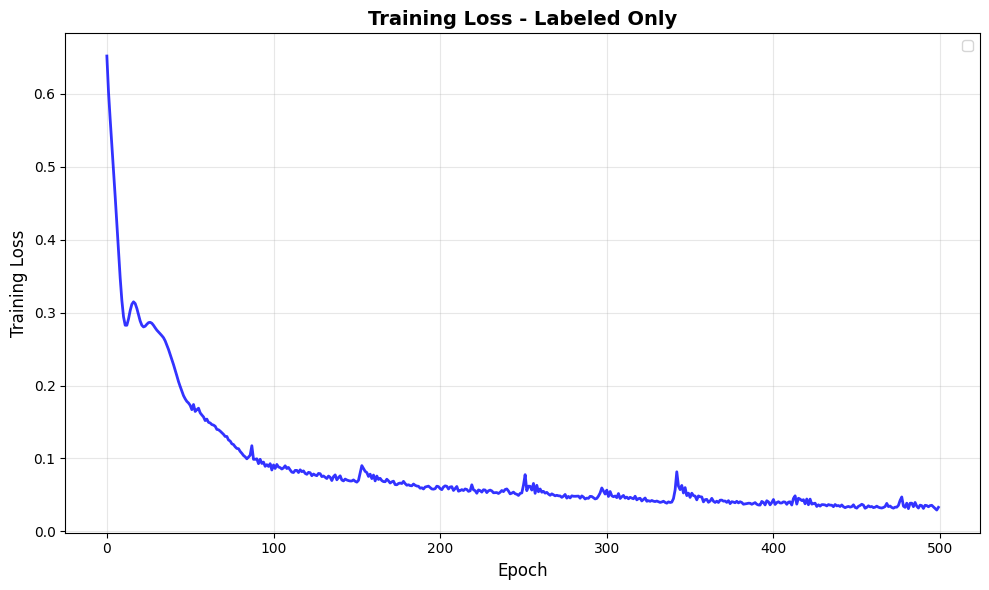

Accuracy: 0.9431222267043162
-------------
ILLICIT METRICS
Precision: 0.41546526867627787
Recall: 0.5503472222222222
F1: 0.47348767737117253
-------------
LICIT METRICS
Precision: 0.9777338376891335
Recall: 0.9622641509433962
F1: 0.969937316105923


In [10]:
plot_train_loss(history)
print_metrics(history)

## Num Samples = 2

In [10]:
# TRAIN MODEL
aggregator = 'maxpool'
num_samples = 2 # Controls number of neighbours to sample from
model, history = start_training(*setup_params(dataset), train_epoch, test_epoch, lr, aggregator, num_samples)

tensor([[ 1.0000e+00,  1.6305e-01,  1.9638e+00,  ...,  6.7780e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -5.0271e-03,  5.7894e-01,  ...,  3.3321e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.4785e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 3.4000e+01, -1.7211e-01, -1.3181e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 3.4000e+01, -1.7298e-01, -8.1852e-02,  ..., -1.4060e-01,
         -1.7609e+00, -1.7610e+00],
        [ 3.4000e+01, -1.7290e-01, -7.0152e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01]])
tensor([1, 1, 1,  ..., 0, 1, 1])
tensor([    0,     1,     2,  ..., 23069, 23070, 23071])
tensor([    2,     4,     8,  ..., 22762, 22974, 22882])
tensor([    3,     5,     9,  ..., 22687, 22730, 22949])
Label distribution: tensor([ 1871, 21201])
Number of nodes: 23072, Number of edges: 45598

STARTING TRAINING...
[166, 166, 166, 166]
TRAINING
Epoch 0, Training Loss

In [14]:
# Save model
torch.save(model.state_dict(), "sage_max_pool.pt")

/tmp/ipython-input-2849774219.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


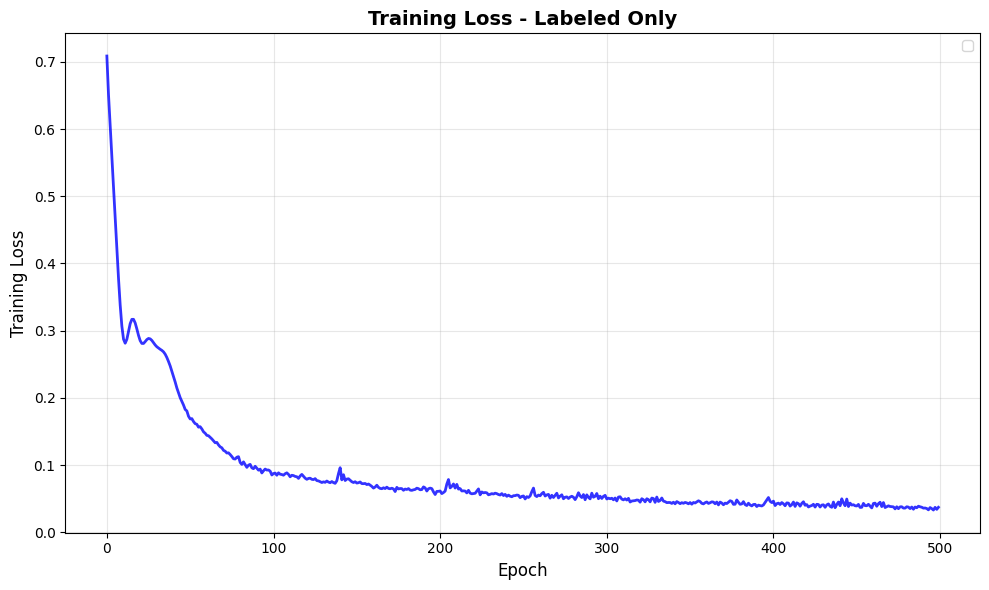

Accuracy: 0.9581282775312626
-------------
ILLICIT METRICS
Precision: 0.5487179487179488
Recall: 0.5572916666666666
F1: 0.5529715762273901
-------------
LICIT METRICS
Precision: 0.9784081287044877
Recall: 0.9776630848633556
F1: 0.9780354648948326


In [13]:
plot_train_loss(history)
print_metrics(history)

## Num Samples = 1

In [9]:
# TRAIN MODEL
aggregator = 'maxpool'
num_samples = 1 # Controls number of neighbours to sample from
model, history = start_training(*setup_params(dataset), train_epoch, test_epoch, lr, aggregator, num_samples)

tensor([[ 1.0000e+00,  1.6305e-01,  1.9638e+00,  ...,  6.7780e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -5.0271e-03,  5.7894e-01,  ...,  3.3321e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.4785e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 3.4000e+01, -1.7211e-01, -1.3181e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 3.4000e+01, -1.7298e-01, -8.1852e-02,  ..., -1.4060e-01,
         -1.7609e+00, -1.7610e+00],
        [ 3.4000e+01, -1.7290e-01, -7.0152e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01]])
tensor([1, 1, 1,  ..., 0, 1, 1])
tensor([    0,     1,     2,  ..., 23069, 23070, 23071])
tensor([    2,     4,     8,  ..., 22762, 22974, 22882])
tensor([    3,     5,     9,  ..., 22687, 22730, 22949])
Label distribution: tensor([ 1871, 21201])
Number of nodes: 23072, Number of edges: 45598

STARTING TRAINING...
[166, 166, 166, 166]
TRAINING
Epoch 0, Training Loss

In [10]:
# Save model
torch.save(model.state_dict(), "sage_max_pool_nsample_1.pt")

/tmp/ipython-input-2849774219.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


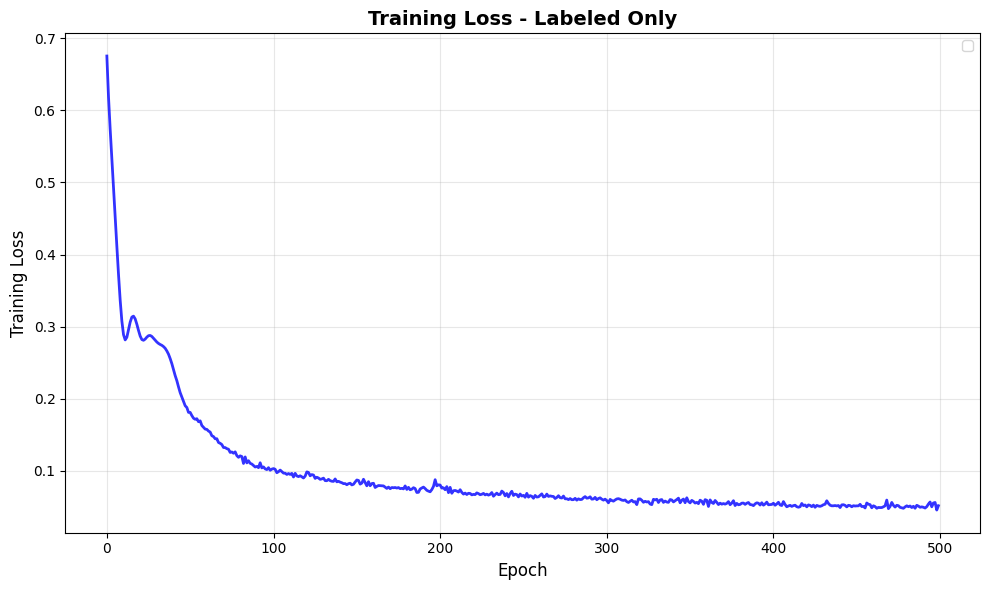

Accuracy: 0.9657119806373538
-------------
ILLICIT METRICS
Precision: 0.675990675990676
Recall: 0.5034722222222222
F1: 0.5771144278606966
-------------
LICIT METRICS
Precision: 0.9760989470165469
Recall: 0.9882392757424486
F1: 0.9821315955434097


In [11]:
plot_train_loss(history)
print_metrics(history)

# Training with Mean Aggregator

In [9]:
# TRAIN MODEL
aggregator = 'mean'
num_samples = 2 # Controls number of neighbours to sample from
model, history = start_training(*setup_params(dataset), train_epoch, test_epoch, lr, aggregator, num_samples)

tensor([[ 1.0000e+00,  1.6305e-01,  1.9638e+00,  ...,  6.7780e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -5.0271e-03,  5.7894e-01,  ...,  3.3321e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.4785e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 3.4000e+01, -1.7211e-01, -1.3181e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 3.4000e+01, -1.7298e-01, -8.1852e-02,  ..., -1.4060e-01,
         -1.7609e+00, -1.7610e+00],
        [ 3.4000e+01, -1.7290e-01, -7.0152e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01]])
tensor([1, 1, 1,  ..., 0, 1, 1])
tensor([    0,     1,     2,  ..., 23069, 23070, 23071])
tensor([    2,     4,     8,  ..., 22762, 22974, 22882])
tensor([    3,     5,     9,  ..., 22687, 22730, 22949])
Label distribution: tensor([ 1871, 21201])
Number of nodes: 23072, Number of edges: 45598

STARTING TRAINING...
[166, 166, 166, 166]
TRAINING
Epoch 0, Training Loss

In [10]:
# Save model
torch.save(model.state_dict(), "sage_mean.pt")

/tmp/ipython-input-2849774219.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


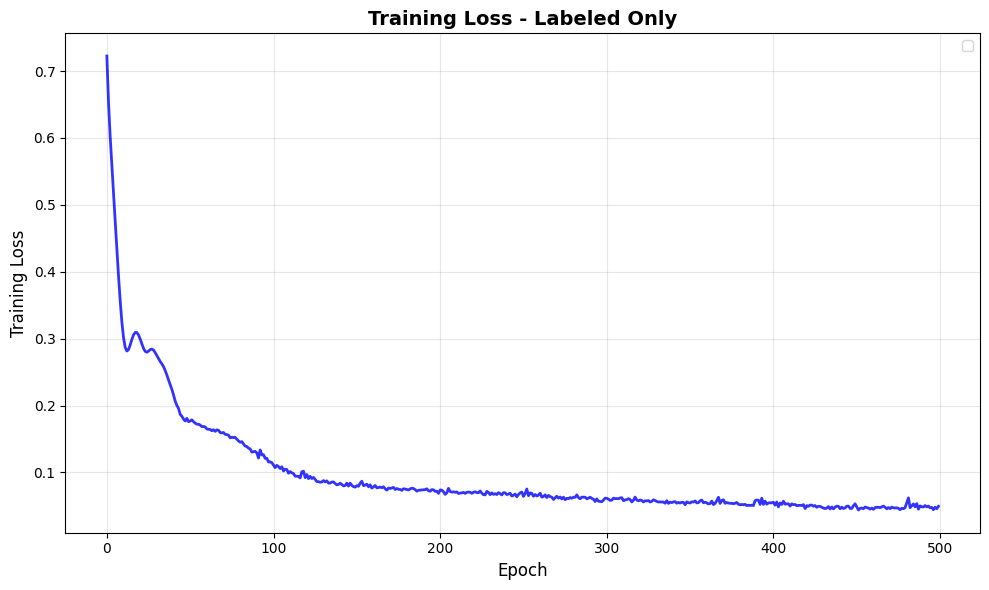

Accuracy: 0.9694231544977814
-------------
ILLICIT METRICS
Precision: 0.7774647887323943
Recall: 0.4791666666666667
F1: 0.5929108485499462
-------------
LICIT METRICS
Precision: 0.9750830564784053
Recall: 0.9933158473644133
F1: 0.9841150090112746


In [11]:
plot_train_loss(history)
print_metrics(history)

# Training with LSTM Aggregator

In [9]:
# TRAIN MODEL
aggregator = 'lstm'
num_samples = 2 # Controls number of neighbours to sample from
model, history = start_training(*setup_params(dataset), train_epoch, test_epoch, lr, aggregator, num_samples)

tensor([[ 1.0000e+00,  1.6305e-01,  1.9638e+00,  ...,  6.7780e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -5.0271e-03,  5.7894e-01,  ...,  3.3321e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.4785e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 3.4000e+01, -1.7211e-01, -1.3181e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 3.4000e+01, -1.7298e-01, -8.1852e-02,  ..., -1.4060e-01,
         -1.7609e+00, -1.7610e+00],
        [ 3.4000e+01, -1.7290e-01, -7.0152e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01]])
tensor([1, 1, 1,  ..., 0, 1, 1])
tensor([    0,     1,     2,  ..., 23069, 23070, 23071])
tensor([    2,     4,     8,  ..., 22762, 22974, 22882])
tensor([    3,     5,     9,  ..., 22687, 22730, 22949])
Label distribution: tensor([ 1871, 21201])
Number of nodes: 23072, Number of edges: 45598

STARTING TRAINING...
[166, 166, 166, 166]
TRAINING
Epoch 0, Training Loss

In [10]:
# Save model
torch.save(model.state_dict(), "sage_lstm.pt")

/tmp/ipython-input-2849774219.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


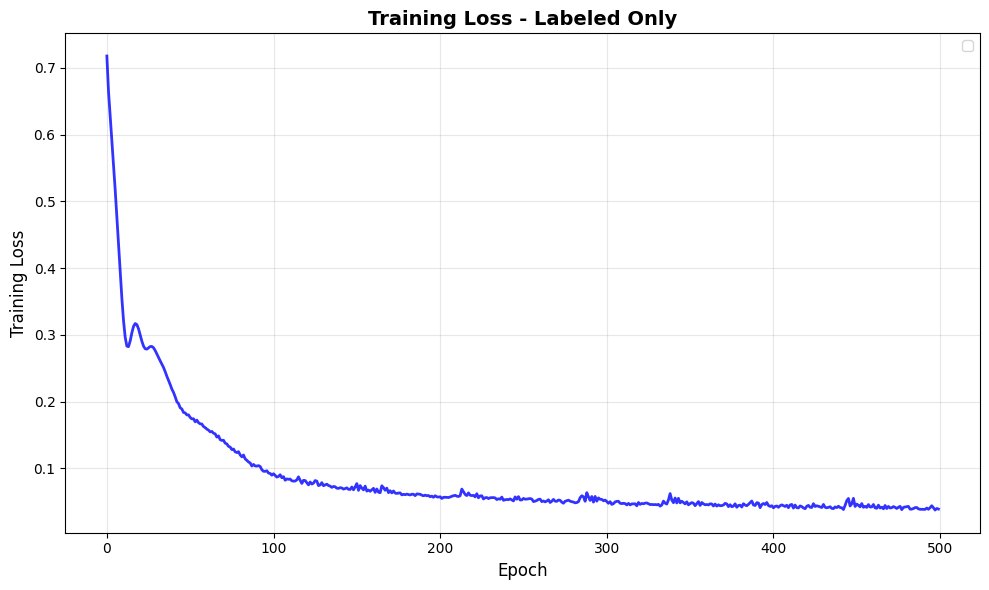

Accuracy: 0.9700685760387253
-------------
ILLICIT METRICS
Precision: 0.7704485488126649
Recall: 0.5069444444444444
F1: 0.6115183246073298
-------------
LICIT METRICS
Precision: 0.9763648468708389
Recall: 0.9926389711481513
F1: 0.9844346549192364


In [11]:
plot_train_loss(history)
print_metrics(history)

# Loading Model

This section is specifically for loading of the model for inference. Do note that the model weights will have to be added in the same directory as this notebook for it load propoerly.

## Max Pool

In [12]:
# Load model
model_path = 'sage_max_pool_nsample_1.pt'
model_load = GraphSAGENodeClassifier(
    input_dim=166,
    hidden_dims=[166, 166],
    num_classes=2, # Licit or illicit only
    aggregator_type='maxpool', # Define type of aggregator here - mean, maxpool, lstm
    num_samples=2 # Define the number of neighbours to sample
)
model_load.load_state_dict(torch.load(model_path, weights_only=True))
model_load.eval()

[166, 166, 166, 166]


GraphSAGENodeClassifier(
  (graphsage): GraphSAGE(
    (layers): ModuleList(
      (0-1): 2 x GraphSAGELayer(
        (dropout): Dropout(p=0.5, inplace=False)
        (aggregator): MaxPoolAggregator(
          (mlp): Sequential(
            (0): Linear(in_features=166, out_features=166, bias=True)
            (1): ReLU()
            (2): Linear(in_features=166, out_features=166, bias=True)
          )
        )
        (self_linear): Linear(in_features=166, out_features=166, bias=True)
        (final_linear): Linear(in_features=332, out_features=166, bias=True)
      )
      (2): GraphSAGELayer(
        (dropout): Dropout(p=0, inplace=False)
        (aggregator): MaxPoolAggregator(
          (mlp): Sequential(
            (0): Linear(in_features=166, out_features=166, bias=True)
            (1): ReLU()
            (2): Linear(in_features=166, out_features=166, bias=True)
          )
        )
        (self_linear): Linear(in_features=166, out_features=166, bias=True)
        (final_lin

## Mean

In [ ]:
# Load model
model_path = 'sage_mean.pt'
model_load = GraphSAGENodeClassifier(
    input_dim=166,
    hidden_dims=[166, 166],
    num_classes=2, # Licit or illicit only
    aggregator_type='mean', # Define type of aggregator here - mean, maxpool, lstm
    num_samples=2 # Define the number of neighbours to sample
)
model_load.load_state_dict(torch.load(model_path, weights_only=True))
model_load.eval()

## LSTM

In [10]:
# Load model
model_path = 'sage_lstm.pt'
model_load = GraphSAGENodeClassifier(
    input_dim=166,
    hidden_dims=[166, 166],
    num_classes=2, # Licit or illicit only
    aggregator_type='lstm', # Define type of aggregator here - mean, maxpool, lstm
    num_samples=2 # Define the number of neighbours to sample
)
model_load.load_state_dict(torch.load(model_path, weights_only=True))
model_load.eval()

[166, 166, 166, 166]


GraphSAGENodeClassifier(
  (graphsage): GraphSAGE(
    (layers): ModuleList(
      (0-1): 2 x GraphSAGELayer(
        (dropout): Dropout(p=0.5, inplace=False)
        (aggregator): LSTMAggregator(
          (lstm): LSTM(166, 166, batch_first=True)
          (linear): Linear(in_features=166, out_features=166, bias=True)
        )
        (self_linear): Linear(in_features=166, out_features=166, bias=True)
        (final_linear): Linear(in_features=332, out_features=166, bias=True)
      )
      (2): GraphSAGELayer(
        (dropout): Dropout(p=0, inplace=False)
        (aggregator): LSTMAggregator(
          (lstm): LSTM(166, 166, batch_first=True)
          (linear): Linear(in_features=166, out_features=166, bias=True)
        )
        (self_linear): Linear(in_features=166, out_features=166, bias=True)
        (final_linear): Linear(in_features=332, out_features=166, bias=True)
      )
    )
  )
  (classifier): Linear(in_features=166, out_features=2, bias=True)
)

## Evaluate model

In [14]:
# Evaluate
graph, features, labels, nodes, graph_v, features_v, labels_v, nodes_v, graph_t, features_t, labels_t, nodes_t = setup_params(dataset)

criterion = nn.CrossEntropyLoss()

logits = model_load(graph_t, features_t, nodes_t)
test_loss = criterion(logits, labels_t)
test_loss_disp = str(round(test_loss.item(), 4))
print(f"Test Loss: {test_loss_disp}")

# Calculate metrics
outputs = logits.cpu().argmax(dim=1).detach().numpy()
labels_t_c = labels_t.cpu().detach().numpy()
acc = accuracy_score(labels_t_c, outputs)
prec = precision_score(labels_t_c, outputs, pos_label=0, zero_division=0)
rec = recall_score(labels_t_c, outputs, pos_label=0, zero_division=0)
f1  = f1_score(labels_t_c, outputs, pos_label=0, zero_division=0)

print("Accuracy: ", acc)
print('-------------')
print('ILLICIT METRICS')
print("Precision: ", prec)
print("Recall: ", rec)
print("F1 Score: ", f1)

prec = precision_score(labels_t_c, outputs, pos_label=1, zero_division=0)
rec = recall_score(labels_t_c, outputs, pos_label=1, zero_division=0)
f1  = f1_score(labels_t_c, outputs, pos_label=1, zero_division=0)

print('-------------')
print('LICIT METRICS')
print("Precision: ", prec)
print("Recall: ", rec)
print("F1 Score: ", f1)
print('-------------')

tensor([[ 1.0000e+00,  1.6305e-01,  1.9638e+00,  ...,  6.7780e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -5.0271e-03,  5.7894e-01,  ...,  3.3321e-01,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.4785e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 3.4000e+01, -1.7211e-01, -1.3181e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 3.4000e+01, -1.7298e-01, -8.1852e-02,  ..., -1.4060e-01,
         -1.7609e+00, -1.7610e+00],
        [ 3.4000e+01, -1.7290e-01, -7.0152e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01]])
tensor([1, 1, 1,  ..., 0, 1, 1])
tensor([    0,     1,     2,  ..., 23069, 23070, 23071])
tensor([    2,     4,     8,  ..., 22762, 22974, 22882])
tensor([    3,     5,     9,  ..., 22687, 22730, 22949])
Label distribution: tensor([ 1871, 21201])
Number of nodes: 23072, Number of edges: 45598
Test Loss: 0.1278
Accuracy:  0.9711980637353772
-------------
ILLICIT METR

# Evaluate timestep

Note: Ensure that model_load is set before running

In [67]:
def create_timestep_graphs(test_data_ds):
  timestep_test_eval_inputs = []
  for t in range(35, 50):
    mask = test_data_ds["features"][:,0] == t
    features_t = test_data_ds["features"][mask]
    labels_t = test_data_ds["labels"][mask]
    nodes_t = test_data_ds["nodes"][mask]

    # Mask edges
    src_t = torch.tensor(test_data_ds["src_nodes"], dtype=torch.long)
    dst_t = torch.tensor(test_data_ds["dest_nodes"], dtype=torch.long)
    src_mask = torch.isin(src_t, nodes_t)
    dst_mask = torch.isin(dst_t, nodes_t)
    combine_edge_mask = torch.logical_and(src_mask, dst_mask)
    src_t = src_t[combine_edge_mask]
    dst_t = dst_t[combine_edge_mask]

    # Update nodes and edges indices
    # else, features and labels indices would not match
    node_mapping = {node_id:i for i, node_id in enumerate(nodes_t.numpy().tolist())}
    remapped_nodes = torch.empty_like(nodes_t, dtype=torch.long)
    for i, val in enumerate(nodes_t):
        remapped_nodes[i] = node_mapping[val.item()]
    nodes_t = remapped_nodes
    remapped_edgelist0 = torch.empty_like(src_t, dtype=torch.long)
    for i, val in enumerate(src_t):
        remapped_edgelist0[i] = node_mapping[val.item()]
    src_t = remapped_edgelist0
    remapped_edgelist1 = torch.empty_like(dst_t, dtype=torch.long)
    for i, val in enumerate(dst_t):
        remapped_edgelist1[i] = node_mapping[val.item()]
    dst_t = remapped_edgelist1

    graph_t = dgl.graph((src_t, dst_t))
    graph_t = dgl.add_self_loop(graph_t)

    timestep_test_eval_inputs.append((t, features_t, labels_t, nodes_t, src_t, dst_t, graph_t))
  return timestep_test_eval_inputs

In [68]:
timestep_test_eval_inputs = create_timestep_graphs(test_data_ds)
illicit_f1_score_arr = []
for data in timestep_test_eval_inputs:
  t, features_t, labels_t, nodes_t, src_t, dst_t, graph_t = data
  print(f"Timestep: {t}")
  criterion = nn.CrossEntropyLoss()

  logits = model_load(graph_t, features_t, nodes_t)
  test_loss = criterion(logits, labels_t)
  test_loss_disp = str(round(test_loss.item(), 4))
  print(f"Test Loss: {test_loss_disp}")

  # Calculate metrics
  outputs = logits.cpu().argmax(dim=1).detach().numpy()
  labels_t_c = labels_t.cpu().detach().numpy()
  acc = accuracy_score(labels_t_c, outputs)
  prec = precision_score(labels_t_c, outputs, pos_label=0, zero_division=0)
  rec = recall_score(labels_t_c, outputs, pos_label=0, zero_division=0)
  f1  = f1_score(labels_t_c, outputs, pos_label=0, zero_division=0)
  illicit_f1_score_arr.append(f1)
  print("Accuracy: ", acc)
  print('-------------')
  print('ILLICIT METRICS')
  print("Precision: ", prec)
  print("Recall: ", rec)
  print("F1 Score: ", f1)

  prec = precision_score(labels_t_c, outputs, pos_label=1, zero_division=0)
  rec = recall_score(labels_t_c, outputs, pos_label=1, zero_division=0)
  f1  = f1_score(labels_t_c, outputs, pos_label=1, zero_division=0)

  print('-------------')
  print('LICIT METRICS')
  print("Precision: ", prec)
  print("Recall: ", rec)
  print("F1 Score: ", f1)
  print('-------------')

Timestep: 35
Test Loss: 0.0716
Accuracy:  0.9811912225705329
-------------
ILLICIT METRICS
Precision:  0.9142857142857143
Recall:  0.8421052631578947
F1 Score:  0.8767123287671232
-------------
LICIT METRICS
Precision:  0.9864712514092446
Recall:  0.9931895573212258
F1 Score:  0.9898190045248869
-------------
Timestep: 36
Test Loss: 0.0303
Accuracy:  0.989935956084172
-------------
ILLICIT METRICS
Precision:  0.5833333333333334
Recall:  0.9333333333333333
F1 Score:  0.717948717948718
-------------
LICIT METRICS
Precision:  0.9990645463049579
Recall:  0.9907235621521335
F1 Score:  0.9948765719608756
-------------
Timestep: 37
Test Loss: 0.1964
Accuracy:  0.9447236180904522
-------------
ILLICIT METRICS
Precision:  0.6153846153846154
Recall:  0.32
F1 Score:  0.42105263157894735
-------------
LICIT METRICS
Precision:  0.9558441558441558
Recall:  0.9865951742627346
F1 Score:  0.9709762532981531
-------------
Timestep: 38
Test Loss: 0.1234
Accuracy:  0.9641744548286605
-------------
ILLICIT

In [71]:
print(illicit_f1_score_arr)

[0.8767123287671232, 0.717948717948718, 0.42105263157894735, 0.8270676691729323, 0.8282828282828283, 0.5871559633027523, 0.6530612244897959, 0.6923076923076923, 0.0, 0.08333333333333333, 0.0, 0.5, 0.0, 0.0, 0.037037037037037035]
